In [1]:
import numpy as np
import os
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


2023-12-08 18:51:13.855219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 18:51:13.855251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 18:51:13.856130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 18:51:13.862602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 18:51:14.535951: W tensorflow/compiler/tf2

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


2023-12-08 18:51:15.639874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:51:15.671475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:51:15.671779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Define image size
IMAGE_SIZE = [299, 299]

# Define your local dataset path
dataset_path = './Dermnet_23/train'

In [5]:
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


2023-12-08 18:51:15.946822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:51:15.947226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:51:15.947515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# Freeze the layers of the Xception base model
for layer in xception.layers:
    layer.trainable = False

# Define the number of classes
num_classes = 26

In [7]:
# Create the model
x = Flatten()(xception.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=xception.input, outputs=prediction)

In [8]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [9]:
# Define the batch size
BATCH_SIZE = 32

# Define the validation split
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

In [10]:
# Load the dataset and automatically split into training and validation sets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,  # Random seed for validation splitting
    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,  # Random seed for validation splitting
    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE)
test_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=TEST_SPLIT,
    subset="validation",
    seed=123,  # Random seed for validation splitting
    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE)


Found 15557 files belonging to 23 classes.
Using 12446 files for training.
Found 15557 files belonging to 23 classes.
Using 3111 files for validation.
Found 15557 files belonging to 23 classes.
Using 1555 files for validation.


In [11]:

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [12]:
if tf.config.list_physical_devices('GPU'):
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
print('Using device:', device_name)

Using device: /GPU:0


In [13]:
# Train the model
with tf.device(device_name):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        verbose=1
    )


Epoch 1/30


2023-12-08 18:51:24.760878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-08 18:51:26.011583: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-08 18:51:26.119580: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-08 18:51:26.819438: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

  1/389 [..............................] - ETA: 46:50 - loss: 54.5514 - accuracy: 0.0938

I0000 00:00:1702041689.928265   86066 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


389/389 [==============================] - 108s 259ms/step - loss: 554.2194 - accuracy: 0.1269 - val_loss: 551.2256 - val_accuracy: 0.1697
Epoch 2/30
389/389 [==============================] - 91s 233ms/step - loss: 415.5795 - accuracy: 0.2325 - val_loss: 595.3988 - val_accuracy: 0.1655
Epoch 3/30
389/389 [==============================] - 100s 253ms/step - loss: 367.7516 - accuracy: 0.3085 - val_loss: 587.2421 - val_accuracy: 0.1700
Epoch 4/30
389/389 [==============================] - 91s 235ms/step - loss: 303.7644 - accuracy: 0.3807 - val_loss: 604.9695 - val_accuracy: 0.1694
Epoch 5/30
389/389 [==============================] - 92s 236ms/step - loss: 281.7552 - accuracy: 0.4248 - val_loss: 593.8432 - val_accuracy: 0.2086
Epoch 6/30
389/389 [==============================] - 92s 236ms/step - loss: 219.8109 - accuracy: 0.4978 - val_loss: 683.5723 - val_accuracy: 0.1800
Epoch 7/30
389/389 [==============================] - 92s 237ms/step - loss: 214.1969 - accuracy: 0.5174 - val_loss

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

49/49 [==============================] - 12s 236ms/step - loss: 1099.2982 - accuracy: 0.2431
Test accuracy: 24.31%


In [15]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

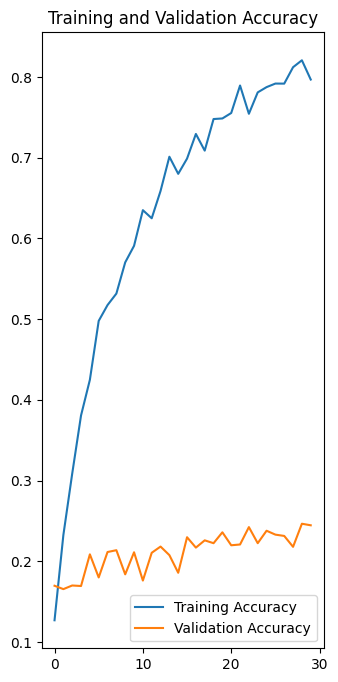

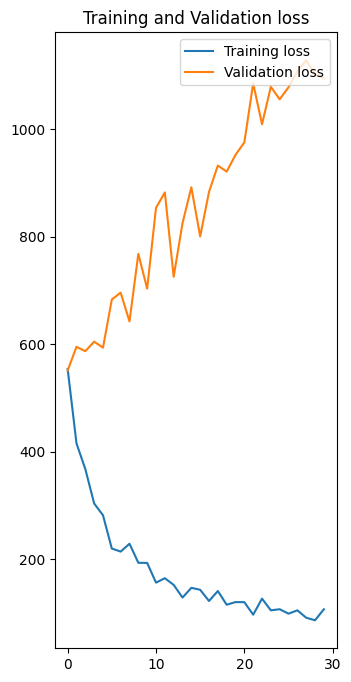

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(30),acc,label='Training Accuracy')
plt.plot(range(30),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


#plot of loss basically the loss should be decrease
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(30),loss,label='Training loss')
plt.plot(range(30),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')